# Job Search IV: Modeling Career Choice


<a id='index-0'></a>

## Contents

- [Job Search IV: Modeling Career Choice](#Job-Search-IV:-Modeling-Career-Choice)  
  - [Overview](#Overview)  
  - [Model](#Model)  
  - [Implementation](#Implementation)  
  - [Exercises](#Exercises)  
  - [Solutions](#Solutions)  

## Overview

Next we study a computational problem concerning career and job choices

The model is originally due to Derek Neal [[Nea99]](https://lectures.quantecon.org/py/zreferences.html#neal1999)

This exposition draws on the presentation in [[LS18]](https://lectures.quantecon.org/py/zreferences.html#ljungqvist2012), section 6.5

We begin with some imports

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import quantecon as qe
from numba import njit, prange
from quantecon.distributions import BetaBinomial
from scipy.special import binom, beta
from mpl_toolkits.mplot3d.axes3d import Axes3D
from matplotlib import cm

### Model features

- Career and job within career both chosen to maximize expected discounted wage flow  
- Infinite horizon dynamic programming with two state variables  

## Model

In what follows we distinguish between a career and a job, where

- a *career* is understood to be a general field encompassing many possible jobs, and  
- a *job*  is understood to be a position with a particular firm  


For workers, wages can be decomposed into the contribution of job and career

- $ w_t = \theta_t + \epsilon_t $, where  
  
  - $ \theta_t $ is contribution of career at time $ t $  
  - $ \epsilon_t $ is contribution of job at time $ t $  
  


At the start of time $ t $, a worker has the following options

- retain a current (career, job) pair $ (\theta_t, \epsilon_t) $
  — referred to hereafter as “stay put”  
- retain a current career $ \theta_t $ but redraw a job $ \epsilon_t $
  — referred to hereafter as “new job”  
- redraw both a career $ \theta_t $ and a job $ \epsilon_t $
  — referred to hereafter as “new life”  


Draws of $ \theta $ and $ \epsilon $ are independent of each other and
past values, with

- $ \theta_t \sim F $  
- $ \epsilon_t \sim G $  


Notice that the worker does not have the option to retain a job but redraw
a career — starting a new career always requires starting a new job

A young worker aims to maximize the expected sum of discounted wages


<a id='equation-exw'></a>
$$
\mathbb{E} \sum_{t=0}^{\infty} \beta^t w_t \tag{1}
$$

subject to the choice restrictions specified above

Let $ v(\theta, \epsilon) $ denote the value function, which is the
maximum of [(1)](#equation-exw) over all feasible (career, job) policies, given the
initial state $ (\theta, \epsilon) $

The value function obeys

$$
v(\theta, \epsilon) = \max\{I, II, III\}
$$

where


<a id='equation-eyes'></a>
$$
\begin{aligned}
& I = \theta + \epsilon + \beta v(\theta, \epsilon) \\
& II = \theta + \int \epsilon' G(d \epsilon') + \beta \int v(\theta, \epsilon') G(d \epsilon') \nonumber \\
& III = \int \theta' F(d \theta') + \int \epsilon' G(d \epsilon') + \beta \int \int v(\theta', \epsilon') G(d \epsilon') F(d \theta') \nonumber
\end{aligned} \tag{2}
$$

Evidently $ I $, $ II $ and $ III $ correspond to “stay put”, “new job” and “new life”, respectively

### Parameterization

As in [[LS18]](https://lectures.quantecon.org/py/zreferences.html#ljungqvist2012), section 6.5, we will focus on a discrete version of the model, parameterized as follows:

- both $ \theta $ and $ \epsilon $ take values in the set
  `np.linspace(0, B, grid_size)` — an even grid of points between
  $ 0 $ and $ B $ inclusive  
- `grid_size = 50`  
- `B = 5`  
- `β = 0.95`  


The distributions $ F $ and $ G $ are discrete distributions
generating draws from the grid points `np.linspace(0, B, grid_size)`

A very useful family of discrete distributions is the Beta-binomial family,
with probability mass function

$$
p(k \,|\, n, a, b)
= {n \choose k} \frac{B(k + a, n - k + b)}{B(a, b)},
\qquad k = 0, \ldots, n
$$

Interpretation:

- draw $ q $ from a Beta distribution with shape parameters $ (a, b) $  
- run $ n $ independent binary trials, each with success probability $ q $  
- $ p(k \,|\, n, a, b) $ is the probability of $ k $ successes in these $ n $ trials  


Nice properties:

- very flexible class of distributions, including uniform, symmetric unimodal, etc.  
- only three parameters  


Here’s a figure showing the effect on the pmf of different shape parameters when $ n=50 $

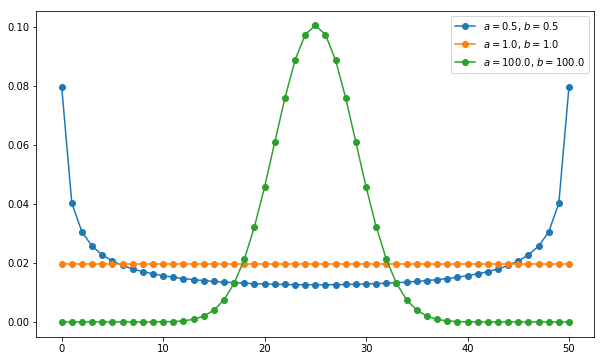

In [2]:
def gen_probs(n, a, b):
    probs = np.zeros(n+1)
    for k in range(n+1):
        probs[k] = binom(n, k) * beta(k + a, n - k + b) / beta(a, b)
    return probs

n = 50
a_vals = [0.5, 1, 100]
b_vals = [0.5, 1, 100]
fig, ax = plt.subplots(figsize=(10, 6))
for a, b in zip(a_vals, b_vals):
    ab_label = f'$a = {a:.1f}$, $b = {b:.1f}$'
    ax.plot(list(range(0, n+1)), gen_probs(n, a, b), '-o', label=ab_label)
ax.legend()
plt.show()

## Implementation

We will first create a class `CareerWorkerProblem` which will hold the
default parameterizations of the model and an initial guess for the value function

In [3]:
class CareerWorkerProblem:

    def __init__(self,
                 B=5.0,          # Upper bound
                 β=0.95,         # Discount factor
                 grid_size=50,   # Grid size
                 F_a=1,
                 F_b=1,
                 G_a=1,
                 G_b=1):

        self.β, self.grid_size, self.B = β, grid_size, B

        self.θ = np.linspace(0, B, grid_size)     # set of θ values
        self.ϵ = np.linspace(0, B, grid_size)     # set of ϵ values

        self.F_probs = BetaBinomial(grid_size - 1, F_a, F_b).pdf()
        self.G_probs = BetaBinomial(grid_size - 1, G_a, G_b).pdf()
        self.F_mean = np.sum(self.θ * self.F_probs)
        self.G_mean = np.sum(self.ϵ * self.G_probs)

        # Store these parameters for str and repr methods
        self._F_a, self._F_b = F_a, F_b
        self._G_a, self._G_b = G_a, G_b

The following function takes and instance of `CareerWorkerProblem` and returns
the corresponding Bellman operator $ T $ and the greedy policy function

In this model, $ T $ is defined by $ Tv(\theta, \epsilon) = \max\{I, II, III\} $, where
$ I $, $ II $ and $ III $ are as given in [(2)](#equation-eyes)

In [4]:
def operator_factory(cw, parallel_flag=True):

    """
    Returns jitted versions of the Bellman operator and the
    greedy policy function

    cw is an instance of ``CareerWorkerProblem``
    """

    θ, ϵ, β = cw.θ, cw.ϵ, cw.β
    F_probs, G_probs = cw.F_probs, cw.G_probs
    F_mean, G_mean = cw.F_mean, cw.G_mean

    @njit(parallel=parallel_flag)
    def T(v):
        "The Bellman operator"

        v_new = np.empty_like(v)

        for i in prange(len(v)):
            for j in prange(len(v)):
                v1 = θ[i] + ϵ[j] + β * v[i, j]                    # stay put
                v2 = θ[i] + G_mean + β * v[i, :] @ G_probs        # new job
                v3 = G_mean + F_mean + β * F_probs @ v @ G_probs  # new life
                v_new[i, j] = max(v1, v2, v3)

        return v_new

    @njit
    def get_greedy(v):
        "Computes the v-greedy policy"

        σ = np.empty(v.shape)

        for i in range(len(v)):
            for j in range(len(v)):
                v1 = θ[i] + ϵ[j] + β * v[i, j]
                v2 = θ[i] + G_mean + β * v[i, :] @ G_probs
                v3 = G_mean + F_mean + β * F_probs @ v @ G_probs
                if v1 > max(v2, v3):
                    action = 1
                elif v2 > max(v1, v3):
                    action = 2
                else:
                    action = 3
                σ[i, j] = action

        return σ

    return T, get_greedy

Lastly, `solve_model` will  take an instance of `CareerWorkerProblem` and
iterate using the Bellman operator to find the fixed point of the value function

In [5]:
def solve_model(cw,
                use_parallel=True,
                tol=1e-4,
                max_iter=1000,
                verbose=True,
                print_skip=25):

    T, _ = operator_factory(cw, parallel_flag=use_parallel)

    # Set up loop
    v = np.ones((cw.grid_size, cw.grid_size)) * 100  # Initial guess
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        v_new = T(v)
        error = np.max(np.abs(v - v_new))
        i += 1
        if verbose and i % print_skip == 0:
            print(f"Error at iteration {i} is {error}.")
        v = v_new

    if i == max_iter:
        print("Failed to converge!")

    if verbose and i < max_iter:
        print(f"\nConverged in {i} iterations.")

    return v_new

Here’s the solution to the model – an approximate value function

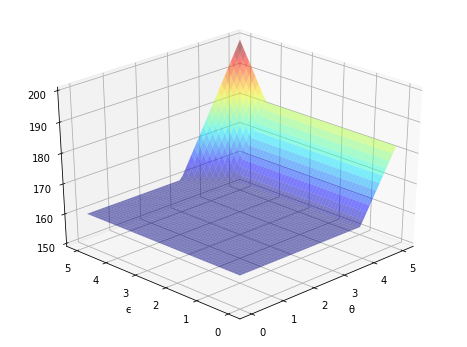

In [6]:
cw = CareerWorkerProblem()
T, get_greedy = operator_factory(cw)
v_star = solve_model(cw, verbose=False)
greedy_star = get_greedy(v_star)

fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
tg, eg = np.meshgrid(cw.θ, cw.ϵ)
ax.plot_surface(tg,
                eg,
                v_star.T,
                cmap=cm.jet,
                alpha=0.5,
                linewidth=0.25)
ax.set(xlabel='θ', ylabel='ϵ', zlim=(150, 200))
ax.view_init(ax.elev, 225)
plt.show()

And here is the optimal policy

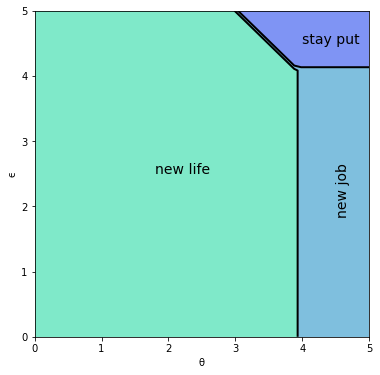

In [7]:
fig, ax = plt.subplots(figsize=(6, 6))
tg, eg = np.meshgrid(cw.θ, cw.ϵ)
lvls = (0.5, 1.5, 2.5, 3.5)
ax.contourf(tg, eg, greedy_star.T, levels=lvls, cmap=cm.winter, alpha=0.5)
ax.contour(tg, eg, greedy_star.T, colors='k', levels=lvls, linewidths=2)
ax.set(xlabel='θ', ylabel='ϵ')
ax.text(1.8, 2.5, 'new life', fontsize=14)
ax.text(4.5, 2.5, 'new job', fontsize=14, rotation='vertical')
ax.text(4.0, 4.5, 'stay put', fontsize=14)
plt.show()

Interpretation:

- If both job and career are poor or mediocre, the worker will experiment with new job and new career  
- If career is sufficiently good, the worker will hold it and experiment with new jobs until a sufficiently good one is found  
- If both job and career are good, the worker will stay put  


Notice that the worker will always hold on to a sufficiently good career, but not necessarily hold on to even the best paying job

The reason is that high lifetime wages require both variables to be large, and
the worker cannot change careers without changing jobs

- Sometimes a good job must be sacrificed in order to change to a better career  

## Exercises


<a id='career-ex1'></a>

### Exercise 1

Using the default parameterization in the class `CareerWorkerProblem`,
generate and plot typical sample paths for $ \theta $ and $ \epsilon $
when the worker follows the optimal policy

In particular, modulo randomness, reproduce the following figure (where the horizontal axis represents time)

<img src="https://s3-ap-southeast-2.amazonaws.com/lectures.quantecon.org/py/_static/figures/career_solutions_ex1_py.png" style="width:60%;height:60%">

  
Hint: To generate the draws from the distributions $ F $ and $ G $, use `quantecon.random.draw()`


<a id='career-ex2'></a>

### Exercise 2

Let’s now consider how long it takes for the worker to settle down to a
permanent job, given a starting point of $ (\theta, \epsilon) = (0, 0) $

In other words, we want to study the distribution of the random variable

$$
T^* := \text{the first point in time from which the worker's job no longer changes}
$$

Evidently, the worker’s job becomes permanent if and only if $ (\theta_t, \epsilon_t) $ enters the
“stay put” region of $ (\theta, \epsilon) $ space

Letting $ S $ denote this region, $ T^* $ can be expressed as the
first passage time to $ S $ under the optimal policy:

$$
T^* := \inf\{t \geq 0 \,|\, (\theta_t, \epsilon_t) \in S\}
$$

Collect 25,000 draws of this random variable and compute the median (which should be about 7)

Repeat the exercise with $ \beta=0.99 $ and interpret the change


<a id='career-ex3'></a>

### Exercise 3

Set the parametization to `G_a = G_b = 100` and generate a new optimal policy
figure – interpret

## Solutions

### Exercise 1

Simulate job / career paths

In reading the code, recall that `optimal_policy[i, j]` = policy at
$ (\theta_i, \epsilon_j) $ = either 1, 2 or 3; meaning ‘stay put’,
‘new job’ and ‘new life’

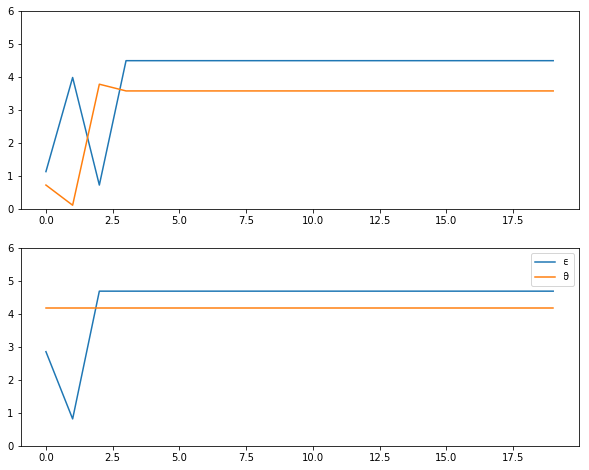

In [8]:
F = np.cumsum(cw.F_probs)
G = np.cumsum(cw.G_probs)
v_star = solve_model(cw, verbose=False)
T, get_greedy = operator_factory(cw)
greedy_star = get_greedy(v_star)

def gen_path(optimal_policy, F, G, t=20):
    i = j = 0
    θ_index = []
    ϵ_index = []
    for t in range(t):
        if greedy_star[i, j] == 1:       # Stay put
            pass
        elif greedy_star[i, j] == 2:     # New job
            j = int(qe.random.draw(G))
        else:                            # New life
            i, j = int(qe.random.draw(F)), int(qe.random.draw(G))
        θ_index.append(i)
        ϵ_index.append(j)
    return cw.θ[θ_index], cw.ϵ[ϵ_index]


fig, axes = plt.subplots(2, 1, figsize=(10, 8))
for ax in axes:
    θ_path, ϵ_path = gen_path(greedy_star, F, G)
    ax.plot(ϵ_path, label='ϵ')
    ax.plot(θ_path, label='θ')
    ax.set_ylim(0, 6)

plt.legend()
plt.show()

### Exercise 2

The median for the original parameterization can be computed as follows

In [9]:
cw = CareerWorkerProblem()
F = np.cumsum(cw.F_probs)
G = np.cumsum(cw.G_probs)
T, get_greedy = operator_factory(cw)
v_star = solve_model(cw, verbose=False)
greedy_star = get_greedy(v_star)

@njit
def passage_time(optimal_policy, F, G):
    t = 0
    i = j = 0
    while True:
        if optimal_policy[i, j] == 1:    # Stay put
            return t
        elif optimal_policy[i, j] == 2:  # New job
            j = int(qe.random.draw(G))
        else:                            # New life
            i, j  = int(qe.random.draw(F)), int(qe.random.draw(G))
        t += 1

@njit(parallel=True)
def median_time(optimal_policy, F, G, M=25000):
    samples = np.empty(M)
    for i in prange(M):
        samples[i] = passage_time(optimal_policy, F, G)
    return np.median(samples)

median_time(greedy_star, F, G)

7.0

To compute the median with $ \beta=0.99 $ instead of the default
value $ \beta=0.95 $, replace `cw = CareerWorkerProblem()` with
`cw = CareerWorkerProblem(β=0.99)`

The medians are subject to randomness, but should be about 7 and 14 respectively

Not surprisingly, more patient workers will wait longer to settle down to their final job

### Exercise 3

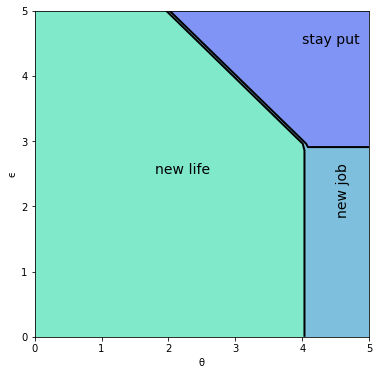

In [10]:
cw = CareerWorkerProblem(G_a=100, G_b=100)
T, get_greedy = operator_factory(cw)
v_star = solve_model(cw, verbose=False)
greedy_star = get_greedy(v_star)

fig, ax = plt.subplots(figsize=(6, 6))
tg, eg = np.meshgrid(cw.θ, cw.ϵ)
lvls = (0.5, 1.5, 2.5, 3.5)
ax.contourf(tg, eg, greedy_star.T, levels=lvls, cmap=cm.winter, alpha=0.5)
ax.contour(tg, eg, greedy_star.T, colors='k', levels=lvls, linewidths=2)
ax.set(xlabel='θ', ylabel='ϵ')
ax.text(1.8, 2.5, 'new life', fontsize=14)
ax.text(4.5, 2.5, 'new job', fontsize=14, rotation='vertical')
ax.text(4.0, 4.5, 'stay put', fontsize=14)
plt.show()

In the new figure, you see that the region for which the worker
stays put has grown because the distribution for $ \epsilon $
has become more concentrated around the mean, making high-paying jobs
less realistic